# Entrenar un Red Convolucionar Sencilla 

In [19]:
import tensorflow as tf 
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D, BatchNormalization, LeakyReLU, Dropout, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

from keras.datasets import cifar10

In [2]:
NUM_CLASES = 10


In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print(x_train.shape)
print(x_test.shape)


(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [4]:
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

y_train = to_categorical(y_train, num_classes=NUM_CLASES)
y_test = to_categorical(y_test,num_classes=NUM_CLASES)


In [16]:
def get_compiled_model():
    input_layer = Input(shape=(32,32,3))
    
    conv_layer_1 = Conv2D(
        filters=10,
        kernel_size=(4,4),
        strides=2,
        padding='same'
        )(input_layer)
    
    conv_layer_2 = Conv2D(
        filters=20,
        kernel_size=(3,3),
        strides=2,
        padding='same'
        )(conv_layer_1)
    
    flatten_layer = Flatten()(conv_layer_2)

    output_layer = Dense(
        units=10,
        activation = 'softmax'
    )(flatten_layer)

    model = Model(input_layer, output_layer)
    model.compile(loss='categorical_crossentropy', optimizer = Adam(lr=0.0005) , metrics=['accuracy'])
    return model

## como se calculan la cantidad de parametros?

la imagen de entrada corresponde a RGB es decir 3 canales, Además son imagenes de 32x32. <br>
ha esta imagen le estamos aplicando 10 filtros de 4x4. <br>
Por lo cual seria para la segunda capa: ((4x4x3)+1)*10 = ((dim_x X dim_y X Canales)+ dim_bias) X numero_filtros = 490  Parametros
Como el Padding es el mismo (no se incrementa la dimension de la imagen), y el Stride (la cantidad de pasos que vamos utilizando para recorrer la matriz) <br>
la forma que sale de conv2d_2 (none, input_height/stride, input_width/stride, cantidad_filtros) <br>
(none, 32/2, 32/2, 10) = (none, 16,16,10) <br>
La cantidad de parametros que son en conv_3 son ((3x3x10)+1)x20 = 1820 <br>
la  que sale de conv2d_3 con una imagen de (none, 8, 8 ,20) que son 1280 parametros los cuales pasan por una capa densa de 10 neuronas generando 12810 parametros




In [17]:
#estrategia con 2 Gpu
strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"],
cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())

print("Cantidad de Gpus {}".format(strategy.num_replicas_in_sync))

with strategy.scope():
    model = get_compiled_model()
model.summary()

Cantidad de Gpus 2
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 10)        490       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 8, 8, 20)          1820      
_________________________________________________________________
flatten_5 (Flatten)          (None, 1280)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                12810     
Total params: 15,120
Trainable params: 15,120
Non-trainable params: 0
_________________________________________________________________


In [18]:
model.fit(x_train, y_train, batch_size=32, epochs=10, shuffle=True, validation_data=(x_test, y_test))

Epoch 1/15
1563/1563 [==============================] - 13s 9ms/step - loss: 1.8650 - accuracy: 0.3468 - val_loss: 1.7698 - val_accuracy: 0.3857
Epoch 2/15
1563/1563 [==============================] - 12s 8ms/step - loss: 1.7460 - accuracy: 0.3992 - val_loss: 1.7253 - val_accuracy: 0.4003
Epoch 3/15
1563/1563 [==============================] - 12s 8ms/step - loss: 1.7195 - accuracy: 0.4130 - val_loss: 1.7245 - val_accuracy: 0.4035
Epoch 4/15
1563/1563 [==============================] - 12s 8ms/step - loss: 1.7066 - accuracy: 0.4177 - val_loss: 1.7160 - val_accuracy: 0.4148
Epoch 5/15
1563/1563 [==============================] - 12s 8ms/step - loss: 1.6983 - accuracy: 0.4198 - val_loss: 1.7096 - val_accuracy: 0.4144
Epoch 6/15
1563/1563 [==============================] - 12s 8ms/step - loss: 1.6915 - accuracy: 0.4232 - val_loss: 1.7189 - val_accuracy: 0.4055
Epoch 7/15
1563/1563 [==============================] - 12s 8ms/step - loss: 1.6856 - accuracy: 0.4279 - val_loss: 1.7049 - val_ac

Como se puede apreciar no se obtiene una buena respuesta del red convolucionar. 
Para ello vamos a noramlizar la salida de cada capa (conv_2) lo cual va dar una mejor estabilidad y rapidez entre capas
y posteriormene vamos a regularizar las capas con Dropout



https://www.youtube.com/watch?v=nUUqwaxLnWs

1. Agregar BachNormalization para la noramlización (tiene un efecto secundario en la regularización ). 
2. Agregar Dropout. 
3. Aumentar la cantidad de muestras en el Batch, debido a menor cantidad de muestras en el bathc la desviacion estandar y el promedio tienen mayor cantidad de ruido.

4. Ademas vamos agrandar la cantidad de capas y filtros en cada etapa



In [26]:
def get_compiled_model_2():
    input_layer = Input(shape=(32,32,3))
    
    x = Conv2D(filters=32 ,kernel_size=(3,3),strides=1,padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(filters=32,kernel_size=(3,3),strides=2,padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(filters=64,kernel_size=(3,3),strides=1,padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(filters=64,kernel_size=(3,3),strides=2,padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Flatten()(x)
    
    x = Dense(units=128)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Dropout(rate = 0.5)(x)

    x = Dense(NUM_CLASES)(x)

    output_layer = Activation('softmax')(x)

    model = Model(input_layer, output_layer)
    model.compile(loss='categorical_crossentropy', optimizer = Adam(lr=0.0005) , metrics=['accuracy'])
    return model

In [27]:
with strategy.scope():
    model = get_compiled_model_2()
model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_10 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 16, 16, 32)        9248      
_________________________________________________________________
batch_normalization_11 (Batc (None, 16, 16, 32)        128       
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 16, 16, 32)        0   

In [28]:
model.fit(x_train, y_train, batch_size=32, epochs=10, shuffle=True, validation_data=(x_test,y_test))

Epoch 1/10
1563/1563 [==============================] - 23s 15ms/step - loss: 1.6035 - accuracy: 0.4420 - val_loss: 1.3150 - val_accuracy: 0.5318
Epoch 2/10
1563/1563 [==============================] - 22s 14ms/step - loss: 1.2017 - accuracy: 0.5783 - val_loss: 0.9898 - val_accuracy: 0.6568
Epoch 3/10
1563/1563 [==============================] - 21s 14ms/step - loss: 1.0666 - accuracy: 0.6288 - val_loss: 1.2243 - val_accuracy: 0.5709
Epoch 4/10
1563/1563 [==============================] - 21s 13ms/step - loss: 0.9837 - accuracy: 0.6585 - val_loss: 0.9056 - val_accuracy: 0.6839
Epoch 5/10
1563/1563 [==============================] - 21s 14ms/step - loss: 0.9191 - accuracy: 0.6818 - val_loss: 0.8636 - val_accuracy: 0.7025
Epoch 6/10
1563/1563 [==============================] - 21s 14ms/step - loss: 0.8724 - accuracy: 0.6981 - val_loss: 0.9270 - val_accuracy: 0.6767
Epoch 7/10
1563/1563 [==============================] - 21s 14ms/step - loss: 0.8223 - accuracy: 0.7141 - val_loss: 0.8225 -

In [33]:
model.evaluate(x_test, y_test, batch_size=1000)

10/10 [==============================] - 0s 15ms/step - loss: 1.0566 - accuracy: 0.6520


[1.0565778017044067, 0.6520000100135803]

In [34]:
CLASSES = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])

preds = model.predict(x_test)
preds_single = CLASSES[np.argmax(preds, axis = -1)]
actual_single = CLASSES[np.argmax(y_test, axis = -1)]

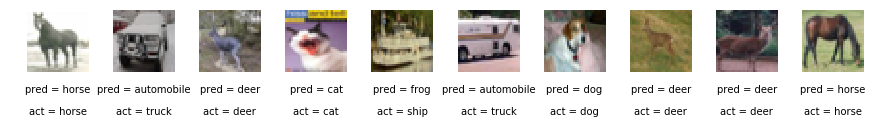

In [35]:
import matplotlib.pyplot as plt

n_to_show = 10
indices = np.random.choice(range(len(x_test)), n_to_show)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, idx in enumerate(indices):
    img = x_test[idx]
    ax = fig.add_subplot(1, n_to_show, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, 'pred = ' + str(preds_single[idx]), fontsize=10, ha='center', transform=ax.transAxes) 
    ax.text(0.5, -0.7, 'act = ' + str(actual_single[idx]), fontsize=10, ha='center', transform=ax.transAxes)
    ax.imshow(img)